# Potential supplementary Figure

In [75]:
wd = "/workspace/projects//immune_biomarkers/repo/immune_biomarkers/"
setwd(wd)

source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_plots.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_settings.R"))
source(paste0(wd,"/mission_control/helpers/figures/themes.R"))

library(tidyverse)
library(ggrepel)
library(data.table)
library(gridExtra)
library(ggpubr)
library(Hmisc)
library(ggh4x)

### Figure 2A

In [76]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))
threshold <- -log10(ingredients$by_05_fdr[1])

In [77]:
drop_features <- c("tcell", "tmb", "prolif","tgfb","pretreat","pretreat_comp","tissue",
                   "tissue_full","age","biopsy","purity","pdl1")

In [78]:
# filter the systemic clinical composite part from the ingredients file
ingredients = ingredients %>%
    filter(!feature %in% drop_features)  %>% 
    filter(feature != "clinical_systemic_composite" & feature != "pretreat") %>% 
    filter(!grepl("cibersort", feature)) %>% 
    mutate(big_group = case_when(big_group == "CNV" ~ "CNV/SVs",
                                 big_group =="SVs" ~ "CNV/SVs", .default = big_group))

In [79]:
set.seed(12345) # set seed to keep the same 'random' order
ingredients$pval_significance = ifelse(ingredients$p_val <= ingredients$by_05_fdr, "sign", "non-sign")
ingredients =  ingredients[sample(nrow(ingredients)),]

In [80]:
level = ingredients$big_group |> table() |> sort(decreasing = TRUE) |> names()
order = order(factor(ingredients$big_group, levels = level)) # make a factor for ordering the data
ingredients = ingredients[order, ]

In [81]:
# Read T-cell features
T_cell_features = data.table::fread("ref/features_Tcell.csv")[[1]] %>% as.character()

In [82]:
ingredients = ingredients  %>% 
    mutate(big_group2 = case_when(feature %in% T_cell_features ~ "RNA: T-cell",
                                 .default = big_group))

### Figure 2B
Visualize clustering of co-correlating features using a correlation-heatmap

In [83]:
ready <- readRDS(paste0(I_DIR, "cpi_go.Rds"))
results <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))
cutoff <- results$by_05_fdr[1]

In [84]:
# filter clinical features to have only a single result
results = results %>% filter(feature != "clinical_systemic_composite")

In [85]:
top_os_df <- results %>% 
    filter(model == "os", dataset == "all", covariates == "age_biopsy_purity_tissue") %>% 
    filter(!feature %in% drop_features) %>%
    filter(!grepl("gene_set_", feature)) %>%
    filter(!grepl("cibersort", feature)) %>%
    filter(!grepl("clinical", feature)) %>%
    filter(!grepl("somatic", feature)) %>%
    filter(!feature %in% T_cell_features)  %>% 
    filter(p_val < cutoff)
top_os_features = top_os_df  %>%  pull(feature)

In [86]:
top_os_go <- ready %>% select(all_of(top_os_features)) %>% drop_na() 
cor_os_pval <- rcorr(as.matrix(top_os_go))
cor_RNA = cor(as.matrix(top_os_go), use = "pairwise.complete.obs")
colnames(cor_RNA) <- colnames(top_os_go)
rownames(cor_RNA) <- colnames(top_os_go)

In [87]:
# Cluster RNA values to be able to split RNA features into a T-cell matrix and two outliers
cor_tree = hclust(dist(1-abs(cor_RNA)), method = "ward.D2")
# set names for the tree-clustering method:
clusters = cutree(cor_tree, 3)
clust = cor_tree

In [88]:
plot_data = cor_RNA %>% as.data.frame()  %>% 
    rownames_to_column("feature_x")  %>% 
    pivot_longer(-feature_x, names_to = "feature_y")  %>% 
    mutate(feature_x = factor(feature_x, levels = colnames(cor_RNA)[rev(clust$order)]),
           feature_y = factor(feature_y, levels = colnames(cor_RNA)[clust$order]))

In [89]:
# check the clustering of the different genes 
clusters2 = cutree(cor_tree, 2)
clusters3 = cutree(cor_tree, 3)
# cluster 2, remains stable when using either 2 or 3 subclusters

# since the main cluster, split into 2 clusters: The main cluster and the smaller one
cluster1_os = names(clusters2)[clusters2 == 1]
cluster2_os = names(clusters2)[clusters2 == 2]

### Figure 3C


In [90]:
# load gene sets
gsea_sets <- readRDS(paste0(REF_DIR,"GSEA_gene_sets.Rds"))
cpi_gene_sets <- readRDS(paste0(REF_DIR,"cpi1000_gene_sets.Rds"))
gsea_sets = gsea_sets[setdiff(names(gsea_sets), names(cpi_gene_sets))]
gene_sets = c(gsea_sets, cpi_gene_sets) # combine the two geneset lists
names(gene_sets) = gsub("gene_set_", "", names(gene_sets))
names(gene_sets) = gsub("gene_set_", "", names(gene_sets))

gene_sets = gene_sets[!grepl("battle_|tgfb_|vhio|08283|rand", names(gene_sets))]

geneset_filtered = data.table::fread("ref/Table_S2_255_genesets.csv")

# rename the geneset names
names(gene_sets) = tolower(names(gene_sets))
idx_mariathan = !names(gene_sets) %in% geneset_filtered$simplename
names(gene_sets)[idx_mariathan] = paste0("m_", names(gene_sets)[idx_mariathan])

In [91]:
top_genes <- ready %>% 
    select(all_of(cluster1_os))

top_genes$cluster_mean = rowMeans(top_genes)
cor_genes<-cor(top_genes, use="pairwise.complete.obs")

In [92]:
gene_sets_expr <- ready %>% select(contains("gene_set_"))
colnames(gene_sets_expr) <- gsub("isofox_|gene_set_", "", colnames(gene_sets_expr))
colnames(gene_sets_expr) = gsub("mariathan_", "m_", colnames(gene_sets_expr))
colnames(gene_sets_expr) = tolower(colnames(gene_sets_expr))

In [93]:
top_genes_with_genesets = cbind(top_genes$cluster_mean, gene_sets_expr)
colnames(top_genes_with_genesets)[1]<-"Cluster_mean"

In [94]:
cor_to_cluster_mean <- data.frame("feature" = colnames(top_genes_with_genesets), 
                                  "Cor_with_cluster" = cor(top_genes_with_genesets,top_genes_with_genesets$Cluster_mean,use="pairwise.complete.obs")[,1])
cor_to_cluster_mean = cor_to_cluster_mean |> mutate(feature = sub("isofox_|gene_set_", "", feature))

In [95]:
os_set_result_geneset = results  %>% 
    filter(model == "os", dataset == "all", covariates == "age_biopsy_purity_tissue") %>%
    filter(Group == "Gene Set") 
os_set_result_geneset$feature = gsub("isofox_|gene_set_", "", os_set_result_geneset$feature)  %>% tolower()
os_set_result_geneset$feature = gsub("mariathan_", "m_", os_set_result_geneset$feature)

In [96]:
tcell_sets = fread("ref/T_cell_genesets.csv")

In [97]:
result2 <- merge(cor_to_cluster_mean, os_set_result_geneset, by="feature")  %>% 
    mutate(selected = case_when(Cor_with_cluster > 0.5 & log10_p > threshold ~ "TGFB-correlated",
                                feature %in% tcell_sets$feature & log10_p > threshold ~ "T-cell correlated", 
                               .default = "gene set"))

In [98]:
result2$Short_name = geneset_filtered$Alias[match(result2$feature, geneset_filtered$simplename)]
result2 = result2  %>% filter(!is.na(Short_name))

In [99]:
result_save = result2  %>% arrange(desc(Cor_with_cluster))  %>% 
    select(feature, contains("group"), selected, Short_name, Cor_with_cluster, log10_p,  starts_with("cor"))
#readr::write_excel_csv(result_save, "1_figures/revised_plots_Axel/Surival_all_cluster1.csv")

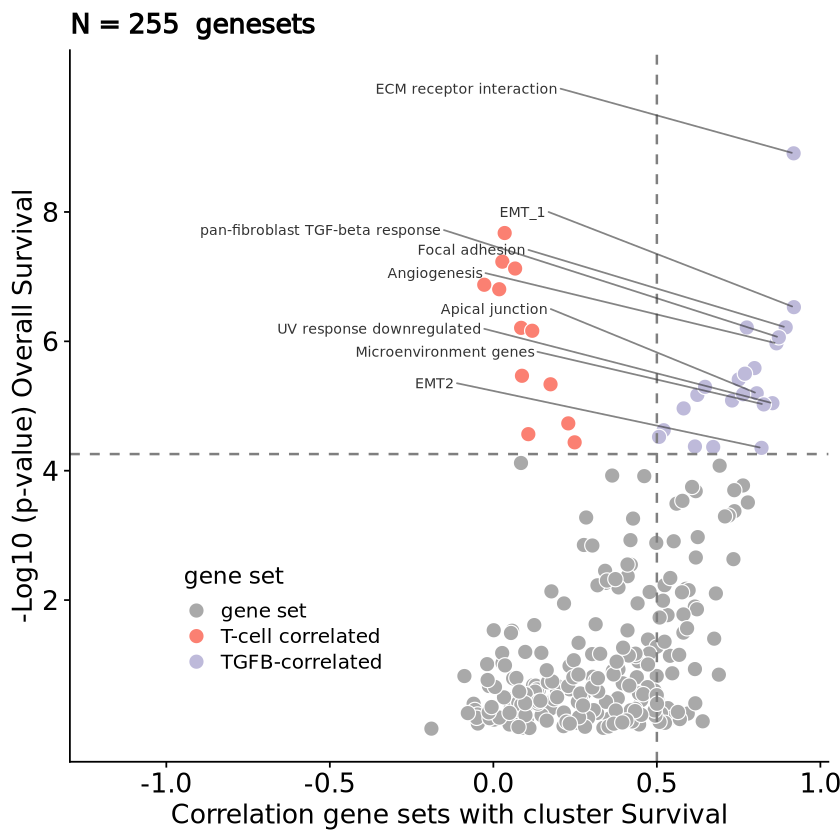

In [100]:
fig3e <- ggplot(result2, aes(x = Cor_with_cluster, y = log10_p, fill = selected)) +
    geom_point(size = 4, shape = 21, color = "white") +
    theme_bw() +
    scale_fill_manual(values=c("darkgrey","#FB8072", "#BEBADA")) +
    geom_vline(xintercept = 0.5, linetype="dashed", color = "grey50", linewidth =.7) +
    geom_hline(yintercept = threshold, linetype="dashed", color = "grey50", linewidth =.7) +
    geom_text_repel(aes(label = if_else((Cor_with_cluster > 0.8 & log10_p > threshold), Short_name, "")), 
                    segment.alpha = 0.6, nudge_y = 1, nudge_x =-1,force = 30,
                    min.segment.length = 0.3, box.padding = 0.2,
                  size=3, col="grey20" ,max.overlaps= Inf )+
    cowplot::theme_cowplot() + 
    theme(legend.position=c(0.15, 0.2)) +
    theme(axis.title=element_text(size=16), axis.text = element_text(size = 16)) +
    scale_y_continuous(breaks = c(2,4,6,8), lim = c(0,10)) +
    labs(x = "Correlation gene sets with cluster Survival", y ="-Log10 (p-value) Overall Survival", 
        title = paste0("N = ",nrow(result2), "  genesets"), fill = "gene set")

fig3e
ggsave("../../final_figures/3e_supplement_scatterplot.pdf", fig3e, width = 5, height = 5)